In [55]:
import pandas as pd
import numpy as np
dirty_data_priora = pd.read_csv('C:\\Users\\Lo_Sci\\Desktop\\Py\\Prio\\Priora_List1.csv')

# подготавливаем цифровые данные
priora_only_input = dirty_data_priora[['дата', 'часы в пути', 'минуты в пути', 'пробег', 'средний расход', 
                                       'температура', 'маршрут', 'топливо', 'откуда', 'до куда']]
priora_num = priora_only_input.rename(columns={'часы в пути': 'hours', 'маршрут': 'km', 'минуты в пути':'minutes'})
priora_num['temperature'] = pd.to_numeric(priora_num['температура'].str.replace(',','.'), errors='coerce')
priora_num['path'] = pd.to_numeric(priora_num['km'].str.replace(',','.'), errors='coerce')
priora_num['hrs'] = priora_num.hours + priora_num.minutes/60
priora_num['fuel'] = pd.to_numeric(priora_num['топливо'].str.replace(',','.'), errors='coerce')
priora_num['time_h'] = np.diff(priora_num.hrs, prepend=0)
priora_num['benz'] = np.diff(priora_num.fuel, prepend=0)
priora_num['distance'] = np.diff(priora_num.path, prepend=0)
priora_num['av_speed'] = priora_num.distance / priora_num.time_h
priora_num['rashod'] = 100 * priora_num.benz / priora_num.distance

priora_num.drop(columns=['откуда', 'до куда']).head()

# отфильтровываем неразумные данные и исключаем нечисловые (вспомогательные информационные) колонки
priora_detailsfree = priora_num[['temperature', 'distance', 'time_h', 'benz', 'av_speed', 'rashod']] \
                    .query('distance > 3 & time_h > 0 & rashod < 50')
priora_detailsfree.head()

,temperature,distance,time_h,benz,av_speed,rashod
2,2.0,32.8,0.633333,2.8,51.789474,8.536585
4,1.0,35.6,0.666667,2.3,53.400000,6.460674
5,24.0,366.2,16.066667,37.2,22.792531,10.158383
6,24.0,5.3,0.083333,0.4,63.600000,7.547170
7,24.0,66.2,1.283333,4.8,51.584416,7.250755


In [56]:
# высчитываем глобальные величины по всей базе
global_sr_ras = 100 * priora_detailsfree.benz.sum() / priora_detailsfree.distance.sum()
global_sr_skor = priora_detailsfree.distance.sum() / priora_detailsfree.time_h.sum()
print(
        'средняя скорось за все время эксплуатации = ', round(global_sr_skor, 2),
        'км/ч, при среднем расходе', round(global_sr_ras, 2), 'л/100км'
     )

средняя скорось за все время эксплуатации =  24.76 км/ч, при среднем расходе 9.82 л/100км


In [76]:
# сделаем регрессию методом K ближайших соседей

In [72]:
# приводим данные в формат, пригодный для обучения модели и обучаем ее
array = priora_detailsfree[['av_speed', 'rashod']].values
X = array[:,:1]
Y = array[:,1]
priora_detailsfree.shape
from sklearn.neighbors import KNeighborsRegressor
knnr = KNeighborsRegressor(n_neighbors = 15)
knnr.fit(X, Y)

KNeighborsRegressor(n_neighbors=15)

In [73]:
# генерируем таблицу для предсказанных результатов и выделяем ряд для работы модели
model_data2 = pd.DataFrame(columns=['vel'])
for i in range(0, 45):
    v = 10+i*2
    model_data2.loc[i] = [v]
model_data2.vel
array = model_data2.values
X_res = array[:,:1]

<AxesSubplot:xlabel='av_speed', ylabel='rashod'>

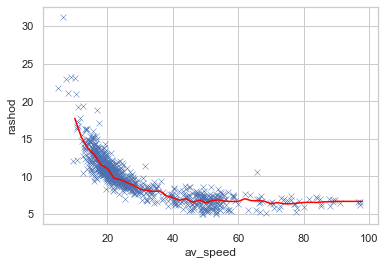

In [74]:
# предсказываем
res = knnr.predict(X_res)
model_data2['pred_rashod'] = pd.Series(res)
import seaborn as sns
sns.scatterplot(data=priora_detailsfree, x='av_speed', y='rashod', marker = 'x')
sns.lineplot(data=model_data2, x='vel', y='pred_rashod', color='red')
# метод ближайших сосоедей дает ломаную кривую, и чувствителен к выбросам

In [ ]:
# сделаем множественную линейную регрессию

In [77]:
x_train = priora_detailsfree[['temperature', 'av_speed']]
x_train['1/v'] = np.power(x_train.av_speed, -1)
x_train['T^2'] = np.power(x_train.temperature, 2)
y_train = priora_detailsfree.rashod
x_train

<ipython-input-77-dd44280890fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['1/v'] = np.power(x_train.av_speed, -1)
<ipython-input-77-dd44280890fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['T^2'] = np.power(x_train.temperature, 2)


,temperature,av_speed,1/v,T^2
2,2.0,51.789474,0.019309,4.0
4,1.0,53.400000,0.018727,1.0
5,24.0,22.792531,0.043874,576.0
6,24.0,63.600000,0.015723,576.0
7,24.0,51.584416,0.019386,576.0
...,...,...,...,...
985,0.0,18.666667,0.053571,0.0
986,0.0,22.625000,0.044199,0.0
987,3.0,21.636923,0.046217,9.0
988,2.0,17.192825,0.058164,4.0


In [79]:
# Обнаружились наны!!! Строки, в которых не указана температура
x_train['BadPoint'] = x_train['temperature'].isnull()
x_train.query('BadPoint == True')

<ipython-input-79-965c6f44c39d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['BadPoint'] = x_train['temperature'].isnull()


,temperature,av_speed,1/v,T^2,BadPoint
453,NaN,22.534562,0.044376,NaN,True
459,NaN,20.857143,0.047945,NaN,True
508,NaN,58.472727,0.017102,NaN,True
600,NaN,17.666667,0.056604,NaN,True
601,NaN,15.315789,0.065292,NaN,True
602,NaN,23.760000,0.042088,NaN,True
603,NaN,21.705882,0.046070,NaN,True
604,NaN,15.230769,0.065657,NaN,True
605,NaN,16.243902,0.061562,NaN,True
757,NaN,19.227273,0.052009,NaN,True


In [82]:
# убираем строчки с нанами из обучающих данных
x_train2 = x_train.dropna().drop('BadPoint', axis=1)
y_train2 = priora_detailsfree.dropna().rashod

In [88]:
# обучаем модель и выводим коэффициенты
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(x_train2, y_train2)
k0 = regr.intercept_
kT, kV, kvobr, kT_2 = regr.coef_
pd.DataFrame(data=regr.coef_, index=x_train2.columns)

,0
temperature,-0.044441
av_speed,0.008839
1/v,130.829420
T^2,0.000703


In [91]:
#коэффициент детерминации модели
regr.score(x_train2, y_train2)

0.8680223063970496

In [92]:
# создаем функцию для предсказания значений расхода от температуры и скорости
def predict_rashod(Temper, Velos):
    return k0+kT*Temper+kT_2*(Temper**2)+kV*Velos+kvobr/Velos

In [93]:
# предсказание (температура, скорость)
predict_rashod(15, 90)

6.060125306788136

<AxesSubplot:xlabel='av_speed', ylabel='rashod'>

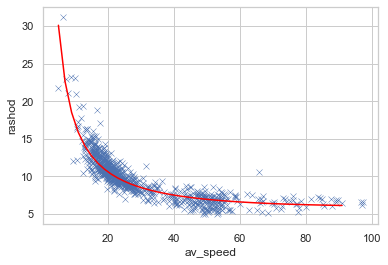

In [96]:
# построим модель предсказания расхода от скорости при средней (по набору данных) температуре
import matplotlib.pyplot as plt
import seaborn as sns

model_data = pd.DataFrame(columns=['vel', 'pred_rashod'])
for i in range(1, 45):
    v = 3+i*2
    pred_rash = predict_rashod(x_train2.temperature.mean(), v)
    model_data.loc[i] = [v, pred_rash]

sns.scatterplot(data=priora_detailsfree, x='av_speed', y='rashod', marker = 'x')
sns.lineplot(data=model_data, x='vel', y='pred_rashod', color='red')

<AxesSubplot:xlabel='temperature', ylabel='rashod'>

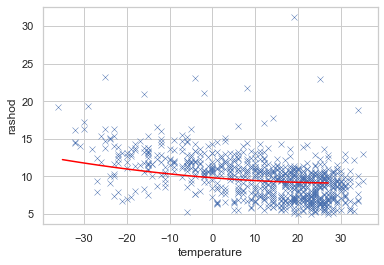

In [97]:
# построим модель предсказания расхода от температуры при средней скорости
model_data_T = pd.DataFrame(columns=['T', 'pred_rashod'])
for i in range(32):
    T = -35+i*2
    pred_rash = predict_rashod(T, global_sr_skor)
    model_data_T.loc[i] = [T, pred_rash]
    
sns.scatterplot(data=priora_detailsfree, x='temperature', y='rashod', marker = 'x')
sns.lineplot(data=model_data_T, x='T', y='pred_rashod', color='red')

In [98]:
# создаем интерактивную модель с изменяемой температурой
from ipywidgets import *
def graph_predict(T):
    global model_data_x
    model_data_x = pd.DataFrame(columns=['vel', 'pred_rashod'])
    selected_temp = priora_detailsfree[(priora_detailsfree.temperature > (T-3)) & (priora_detailsfree.temperature < (T+3))]
    for i in range(1, 45):
        Velos = 3+i*2
        pred_rash = k0+kT*T+kT_2*(T**2)+kV*Velos+kvobr/Velos
        model_data_x.loc[i] = [Velos, pred_rash]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=priora_detailsfree, x='av_speed', y='rashod', marker = 'x')
    sns.scatterplot(data=selected_temp, x='av_speed', y='rashod', marker = 'o', color='orange', s=50)
    sns.lineplot(data=model_data_x, x='vel', y='pred_rashod', color='red')

interact(graph_predict, T=IntSlider(min=-35, max=35, step=1,
                                    value=priora_detailsfree.temperature.mean(),
                                    layout=Layout(width='500px')))

interactive(children=(IntSlider(value=11, description='T', layout=Layout(width='500px'), max=35, min=-35), Out…

<function __main__.graph_predict(T)>